# Prune Dataset to extract representative subset

In this notebook example, we will demonstrate the process of creating a pruned dataset, which is a representative subset of the original dataset. By working with a smaller, yet representative, subset of the training data, we can observe how the model's performance is affected in terms of accuracy and convergence speed. Through this, we can check accuracy drop and convergence time with subset of training data through [OpenVINO™ Training Extensions](https://github.com/openvinotoolkit/training_extensions). This analysis provides valuable insights into the relationship between dataset size and model performance. It helps us understand the scalability and generalization capabilities of the model, shedding light on the efficiency of training algorithms and the potential benefits of working with a pruned dataset. It also allows us to assess the impact of dataset size on model performance, providing guidance for resource allocation and model development in practical scenarios.

## Prerequisite 
### Download Caltech-101 dataset
This is [a download link for caltech101 dataset in Kaggle](https://www.kaggle.com/datasets/imbikramsaha/caltech-101?resource=download). Please download using this link and extract to your workspace directory. Then, you will have a `caltech-101` directory with images in imagenet format as follows.
```bash
caltech-101
├── accordion
│   ├── image_0001.jpg
│   ├── image_0002.jpg
│   ├── ...
├── airplanes
│   ├── image_0001.jpg
│   ├── image_0002.jpg
│   ├── ...
│ ...
└── yin_yang
    ├── image_0001.jpg
    ├── image_0002.jpg
    ├── ...
```

### Install OpenVINO™ Training Extensions
For more details, please see this [OpenVINO™ Training Extensions installation guide](https://openvinotoolkit.github.io/training_extensions/latest/guide/get_started/quick_start_guide/installation.html).

In [ ]:
!pip install otx

## Prune dataset using Datumaro Python API

In this section, we utilize the Dataumaro Python API to prune entire dataset. We import the caltech-101 dataset and apply dataset prune.

In [1]:
import datumaro as dm
from datumaro.components.algorithms.hash_key_inference.prune import Prune

dataset = dm.Dataset.import_from("caltech-101", format="imagenet")
dataset

2023-07-08 01:40:37.166610: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 01:40:37.725001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Dataset
	size=9144
	source_path=caltech-101
	media_type=<class 'datumaro.components.media.Image'>
	annotated_items_count=9144
	annotations_count=9144
subsets
	default: # of items=9144, # of annotated items=9144, # of annotations=9144, annotation types=['label']
infos
	categories
	label: ['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop

### Generate the validation report

Before pruning entire dataset, we first generate the validation report of dataset to confirm the statistics of dataset labels.

In [2]:
from datumaro.plugins.validators import ClassificationValidator
from matplotlib import pyplot as plt

validator = ClassificationValidator()
reports = validator.validate(dataset)

The label distribution in the entire dataset is as follows.

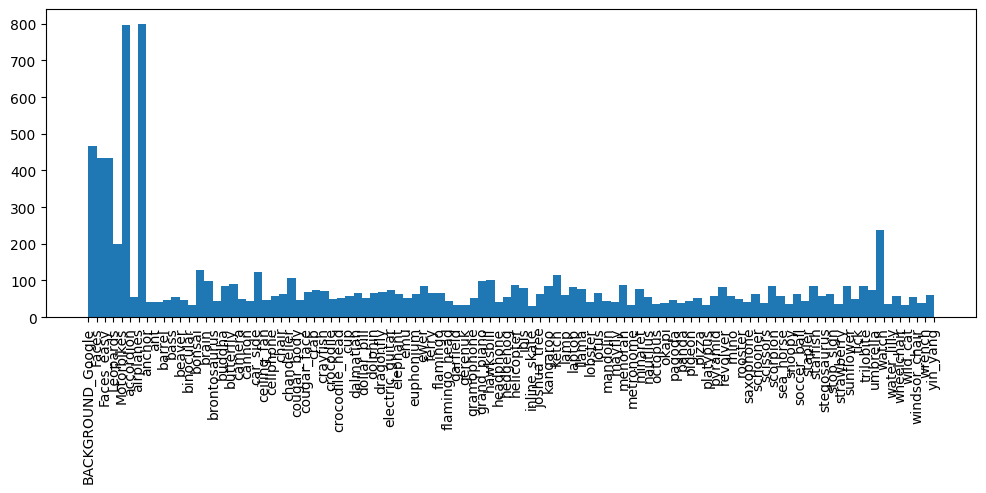

In [3]:
stats = reports["statistics"]

label_stats = stats["label_distribution"]["defined_labels"]
label_name, label_counts = zip(*[(k, v) for k, v in label_stats.items()])

plt.figure(figsize=(12, 4))
plt.hist(label_name, weights=label_counts, bins=len(label_name))
plt.xticks(rotation="vertical")
plt.show()

### Prune dataset
We support various prune methods in [Datumaro](https://github.com/openvinotoolkit/datumaro). We will try each method and compare the results by examining the train and validation reports. We will start by checking using the `random` method. For all methods, we will use a ratio of `0.5`.

The random method involves randomly selecting dataset items from the entire dataset to create a subset.

In [4]:
prune = Prune(dataset, cluster_method="random")
random_result = prune.get_pruned(0.5)

When creating a subset using the random method, as shown below, we can observe that the label distribution changes.

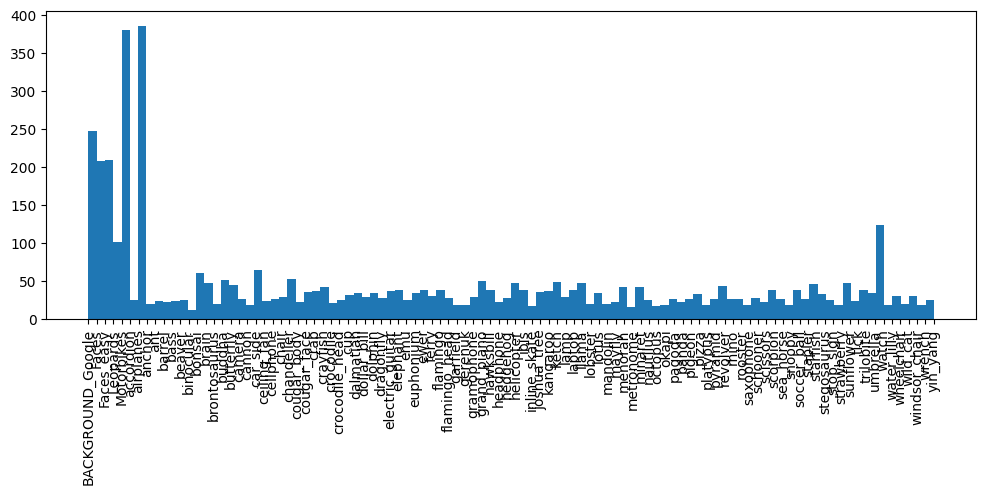

In [5]:
random_reports = validator.validate(random_result)

random_stats = random_reports["statistics"]

label_stats = random_stats["label_distribution"]["defined_labels"]
label_name, label_counts = zip(*[(k, v) for k, v in label_stats.items()])

plt.figure(figsize=(12, 4))
plt.hist(label_name, weights=label_counts, bins=len(label_name))
plt.xticks(rotation="vertical")
plt.show()

In this case, we use `cluster_random` method. For detail information about each method, please refer [prune](https://openvinotoolkit.github.io/datumaro/latest/docs/command-reference/context_free/prune).

In [6]:
prune = Prune(dataset, cluster_method="cluster_random")
cluster_random_result = prune.get_pruned(0.5)

When creating a subset using the cluster random method, as shown below, we can observe that the label distribution changes. In the case of this dataset, the distribution of each class did not change significantly.

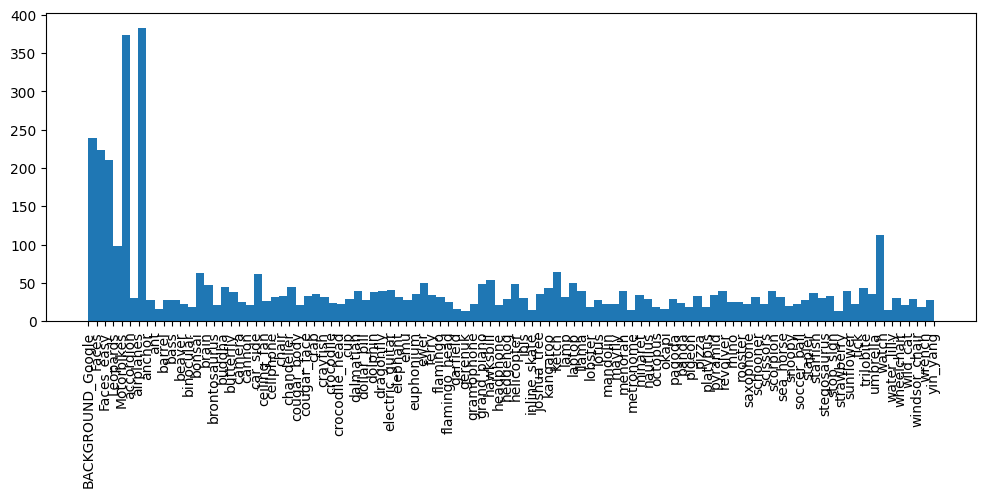

In [7]:
cluster_random_reports = validator.validate(cluster_random_result)

cluster_random_stats = cluster_random_reports["statistics"]

label_stats = cluster_random_stats["label_distribution"]["defined_labels"]
label_name, label_counts = zip(*[(k, v) for k, v in label_stats.items()])

plt.figure(figsize=(12, 4))
plt.hist(label_name, weights=label_counts, bins=len(label_name))
plt.xticks(rotation="vertical")
plt.show()

We use `query_clust` method. For detail information about each method, please refer [prune](https://openvinotoolkit.github.io/datumaro/latest/docs/command-reference/context_free/prune).

In [8]:
prune = Prune(dataset, cluster_method="query_clust")
query_clust_result = prune.get_pruned(0.5)

When creating a subset using the query clust method, as shown below, we can observe that the label distribution changes. In the caltech-101 dataset, when the datasets included in each class were small, there is a tendency for the ratio of classes with more data to increase compared to the datasets of those classes. This tendency may vary for different datasets, so we recommend comparing different methods directly on your own data.

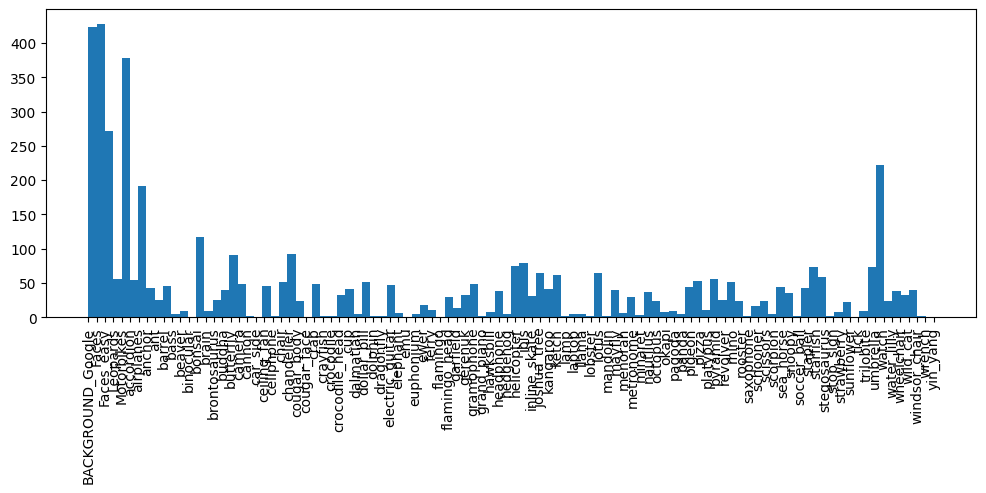

In [9]:
query_clust_reports = validator.validate(query_clust_result)

query_clust_stats = query_clust_reports["statistics"]

label_stats = query_clust_stats["label_distribution"]["defined_labels"]
label_name, label_counts = zip(*[(k, v) for k, v in label_stats.items()])

plt.figure(figsize=(12, 4))
plt.hist(label_name, weights=label_counts, bins=len(label_name))
plt.xticks(rotation="vertical")
plt.show()

We use `centroid` method. For detail information about each method, please refer [prune](https://openvinotoolkit.github.io/datumaro/latest/docs/command-reference/context_free/prune).

In [10]:
prune = Prune(dataset, cluster_method="centroid")
centroid_result = prune.get_pruned(0.5)

When creating a subset using the centroid method, as shown below, we can observe that the label distribution changes. In this case, we can see that the proportion of motorbike, which had a large amount of dataset, has decreased. This illustrates the tendency of certain classes to have a reduced proportion of their data within the overall dataset. It is possible to identify such trends where the contribution of data from specific classes decreases within the entire dataset.

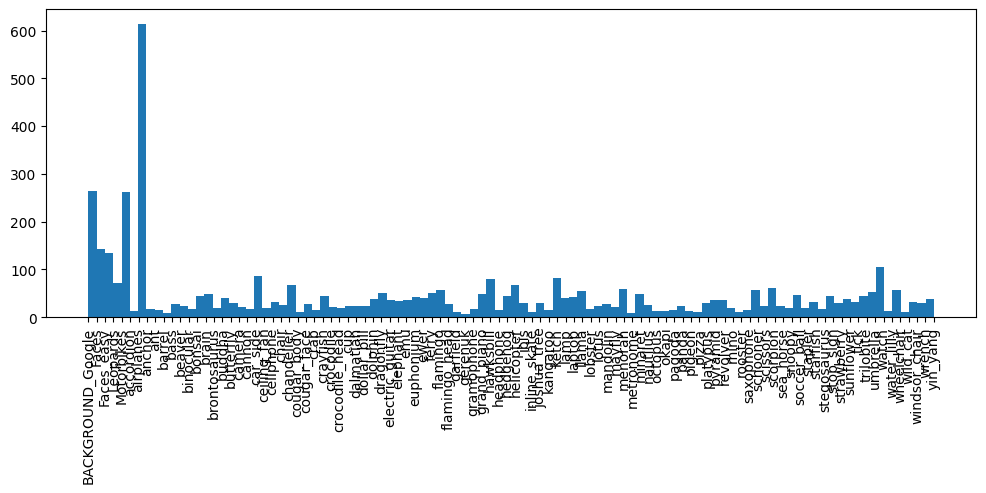

In [11]:
centroid_reports = validator.validate(centroid_result)

centroid_stats = centroid_reports["statistics"]

label_stats = centroid_stats["label_distribution"]["defined_labels"]
label_name, label_counts = zip(*[(k, v) for k, v in label_stats.items()])

plt.figure(figsize=(12, 4))
plt.hist(label_name, weights=label_counts, bins=len(label_name))
plt.xticks(rotation="vertical")
plt.show()

We use `entropy` method. For detail information about each method, please refer [prune](https://openvinotoolkit.github.io/datumaro/latest/docs/command-reference/context_free/prune).

In [12]:
prune = Prune(dataset, cluster_method="entropy")
entropy_result = prune.get_pruned(0.5)

When creating a subset using the entropy method, as shown below, we can observe that the label distribution changes.

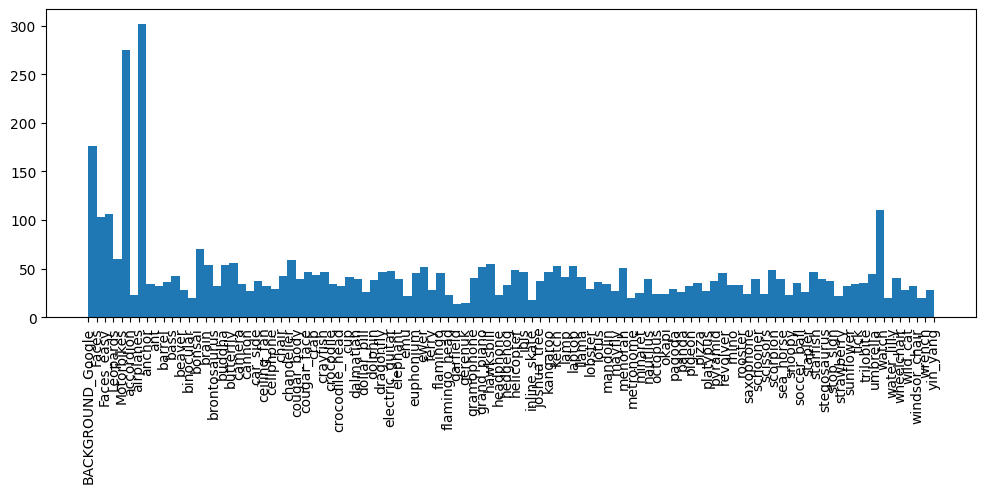

In [13]:
entropy_reports = validator.validate(entropy_result)

entropy_stats = entropy_reports["statistics"]

label_stats = entropy_stats["label_distribution"]["defined_labels"]
label_name, label_counts = zip(*[(k, v) for k, v in label_stats.items()])

plt.figure(figsize=(12, 4))
plt.hist(label_name, weights=label_counts, bins=len(label_name))
plt.xticks(rotation="vertical")
plt.show()

Finally, we use `ndr` method. For detail information about each method, please refer [prune](https://openvinotoolkit.github.io/datumaro/latest/docs/command-reference/context_free/prune).

In [14]:
prune = Prune(dataset, cluster_method="ndr")
ndr_result = prune.get_pruned(0.5)

When creating a subset using the ndr method, as shown below, we can observe that the label distribution changes.

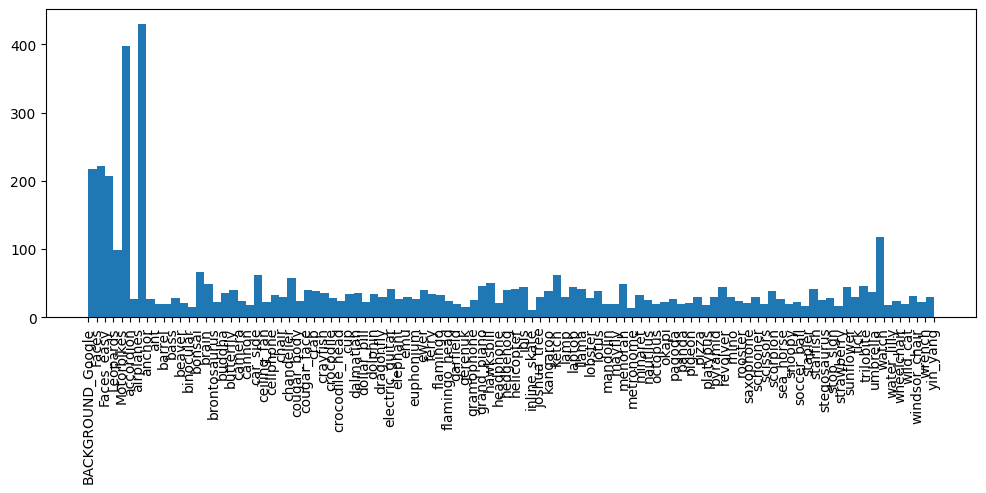

In [15]:
ndr_reports = validator.validate(ndr_result)

ndr_stats = ndr_reports["statistics"]

label_stats = ndr_stats["label_distribution"]["defined_labels"]
label_name, label_counts = zip(*[(k, v) for k, v in label_stats.items()])

plt.figure(figsize=(12, 4))
plt.hist(label_name, weights=label_counts, bins=len(label_name))
plt.xticks(rotation="vertical")
plt.show()

We export those pruned subset to train the model with OpenVINO™ Training Extensions.

In [16]:
random_result.export("random_result", format="datumaro", save_media=True)
cluster_random_result.export("cluster_random_result", format="datumaro", save_media=True)
query_clust_result.export("query_clust_result", format="datumaro", save_media=True)
centroid_result.export("centroid_result", format="datumaro", save_media=True)
entropy_result.export("entropy_result", format="datumaro", save_media=True)
ndr_result.export("ndr_result", format="datumaro", save_media=True)

## Train Model and Export the Trained Classification Model Using OpenVINO™ Training Extensions

In this step, we train a classification model using OTX. To see the detail guides for OpenVINO™ Training Extensions usage, please see [How-To-Train](https://openvinotoolkit.github.io/training_extensions/latest/guide/tutorials/base/how_to_train/classification.html). In this example, we use the CLI command to train the model and choose `EfficientNet-B0` model supported by OpenVINO™ Training Extensions.

In [1]:
!otx train EfficientNet-B0 \
    --train-data-roots caltech-101 \
    --val-data-roots caltech-101 \
    -o outputs

[*] Workspace Path: otx-workspace-CLASSIFICATION
[*] Load Model Template ID: Custom_Image_Classification_EfficinetNet-B0
[*] Load Model Name: EfficientNet-B0
/home/dwekr/miniconda3/envs/datum/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2023-07-10 18:25:50,278 | WARNING : Duplicate key is detected among bases [{'model'}]
[*] 	- Updated: otx-workspace-CLASSIFICATION/model.py
2023-07-10 18:25:50,307 | WARNING : Duplicate key is detected among bases [{'model'}]
[*] 	- Updated: otx-workspace-CLASSIFICATION/model_multilabel.py
[*] 	- Updated: otx-workspace-CLASSIFICATION/data_pipeline.py
[*] 	- Updated: otx-workspace-CLASSIFICATIO

When training with the entire caltech-101 dataset, the best accuracy is `0.9995625305175782` and the training time is 9 minutes and 51 seconds.

In [29]:
!otx train EfficientNet-B0 \
    --train-data-roots random_result \
    --val-data-roots random_result \
    -o outputs_random

[*] Workspace Path: otx-workspace-CLASSIFICATION
[*] Load Model Template ID: Custom_Image_Classification_EfficinetNet-B0
[*] Load Model Name: EfficientNet-B0
/home/dwekr/miniconda3/envs/datum/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2023-07-08 03:58:52,794 | WARNING : Duplicate key is detected among bases [{'model'}]
[*] 	- Updated: otx-workspace-CLASSIFICATION/model.py
2023-07-08 03:58:52,823 | WARNING : Duplicate key is detected among bases [{'model'}]
[*] 	- Updated: otx-workspace-CLASSIFICATION/model_multilabel.py
[*] 	- Updated: otx-workspace-CLASSIFICATION/data_pipeline.py
[*] 	- Updated: otx-workspace-CLASSIFICATIO

When pruning the dataset using the `random` method with a ratio of `0.5`, the best accuracy achieved is `0.9997812652587891` and the training time is 5 minutes and 16 seconds. There was a 46.55% reduction in time while maintaining similar performance.

In [30]:
!otx train EfficientNet-B0 \
    --train-data-roots centroid_result \
    --val-data-roots centroid_result \
    -o output_centroid

[*] Workspace Path: otx-workspace-CLASSIFICATION
[*] Load Model Template ID: Custom_Image_Classification_EfficinetNet-B0
[*] Load Model Name: EfficientNet-B0
/home/dwekr/miniconda3/envs/datum/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2023-07-08 04:14:17,920 | WARNING : Duplicate key is detected among bases [{'model'}]
[*] 	- Updated: otx-workspace-CLASSIFICATION/model.py
2023-07-08 04:14:17,949 | WARNING : Duplicate key is detected among bases [{'model'}]
[*] 	- Updated: otx-workspace-CLASSIFICATION/model_multilabel.py
[*] 	- Updated: otx-workspace-CLASSIFICATION/data_pipeline.py
[*] 	- Updated: otx-workspace-CLASSIFICATIO

When pruning the dataset using the `cluster_random` method with a ratio of `0.5`, the best accuracy achieved is `1.0` and the training time is 4 minutes and 24 seconds. We achieved a time reduction of 46.55% while maintaining similar performance.

When using only 50% of the entire dataset, both `random` and `cluster_random` methods show performance that is sufficiently good compared to using the entire dataset. Therefore, by creating a representative subset, we can train the model in less time without significant drops in performance.